In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torchvision import transforms

transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset, val_dataset = random_split(MNIST(root='./ds', download = True, train = True, transform = transf), [50000, 10000])
test_dataset = MNIST(root = './ds', download = True, train = False, transform = transf)

100%|██████████| 9912422/9912422 [00:00<00:00, 88026320.10it/s]


Extracting ./ds/MNIST/raw/train-images-idx3-ubyte.gz to ./ds/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59293046.41it/s]


Extracting ./ds/MNIST/raw/train-labels-idx1-ubyte.gz to ./ds/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27006339.31it/s]


Extracting ./ds/MNIST/raw/t10k-images-idx3-ubyte.gz to ./ds/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12871978.90it/s]

Extracting ./ds/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./ds/MNIST/raw



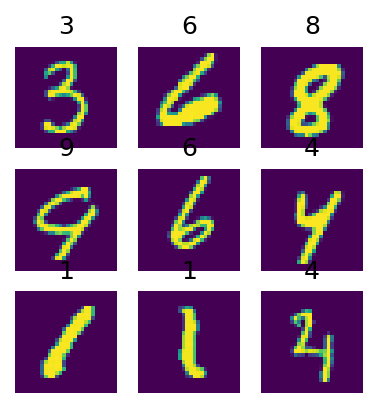

In [2]:
from matplotlib import pyplot as plt
import random

plt.figure(figsize = (3, 3), dpi = 150)
for i in range(9):
    plt.subplot(3, 3, i+1)
    img, label = train_dataset[random.randint(0,50000)]
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze())
plt.show()

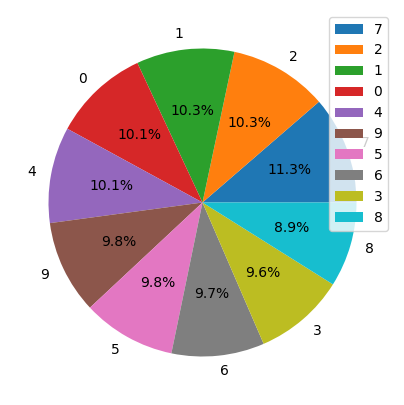

In [30]:
import pandas as pd

inf_df = pd.DataFrame(test_dataset.targets, columns = ['labels'])
figure = plt.figure(figsize =(5, 5))
plt.pie(inf_df['labels'].value_counts(), labels = inf_df['labels'].unique(), autopct = '%1.1f%%')
plt.legend()

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True, num_workers=2)

In [7]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cl1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride = 2))
        self.cl2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size = 1, stride = 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(),
                                nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
          logits = self.cl1(x)
          logits = self.cl2(logits)
          logits = logits.view(-1, 7 * 7 * 64)
          logits = self.fc1(logits)
          logits = self.fc2(logits)
          return logits

In [33]:
from torch import argmax
from torch import save
from torch import optim
from torch import set_grad_enabled

def train(train_dataloader, val_dataloader, model, optimizer, criterion = nn.CrossEntropyLoss(), total_epoch = 10):
    min_loss = 100
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    history = {'train_loss':[], 'val_loss':[]}
    for epoch in range(total_epoch):
        train_loss_epoch, val_loss_epoch = [], []
        model.train()
        for X_batch, Y_batch in train_dataloader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            train_loss_epoch.append(loss.item())
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        for X_val, Y_val in val_dataloader:
            with set_grad_enabled(False):
                output = model(X_val)
                loss = criterion(output, Y_val)
                val_loss_epoch.append(loss.item())

        history['train_loss'].append(sum(train_loss_epoch)/len(train_loss_epoch))
        history['val_loss'].append(sum(val_loss_epoch)/len(val_loss_epoch))

        if(history['val_loss'][-1] < min_loss):
            save(model.state_dict(), './ConvNet')
            min_loss = history['val_loss'][-1]

        print(f"epoch: {epoch}, train_loss: {history['train_loss'][-1]}, val_loss: {history['val_loss'][-1]}")

    return history

In [34]:
model = ConvNet()
total_epoch = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 3e-4)

history = train_loss, val_loss = train(train_dataloader, val_dataloader, model, optimizer, criterion, total_epoch)

epoch: 0, train_loss: 0.1571234830936817, val_loss: 0.0656607586936432
epoch: 1, train_loss: 0.061289756471002974, val_loss: 0.05419020702065841
epoch: 2, train_loss: 0.044338037664948454, val_loss: 0.053866133406375694
epoch: 3, train_loss: 0.035570285503838575, val_loss: 0.08278339083089974
epoch: 4, train_loss: 0.03500606159904495, val_loss: 0.08647747601717592
epoch: 5, train_loss: 0.027876707240263834, val_loss: 0.04903856911961116
epoch: 6, train_loss: 0.021006740586696472, val_loss: 0.049431456507475206
epoch: 7, train_loss: 0.0057572098250400355, val_loss: 0.036351735053317874
epoch: 8, train_loss: 0.003200686514978223, val_loss: 0.034453195152865615
epoch: 9, train_loss: 0.002513023450670107, val_loss: 0.036382507581217804
epoch: 10, train_loss: 0.0016861141835461018, val_loss: 0.03574230852215696
epoch: 11, train_loss: 0.001338706824804782, val_loss: 0.03777815380501333
epoch: 12, train_loss: 0.0011555482894705525, val_loss: 0.038638351092776
epoch: 13, train_loss: 0.00090152

In [40]:
from torch import load

model.load_state_dict(load('./ConvNet'))

In [36]:
pd.DataFrame({'train_loss':[history['train_loss']]}).to_csv('./train_loss.csv', index = False)
pd.DataFrame({'val_loss':[history['val_loss']]}).to_csv('./val_loss.csv', index = False)

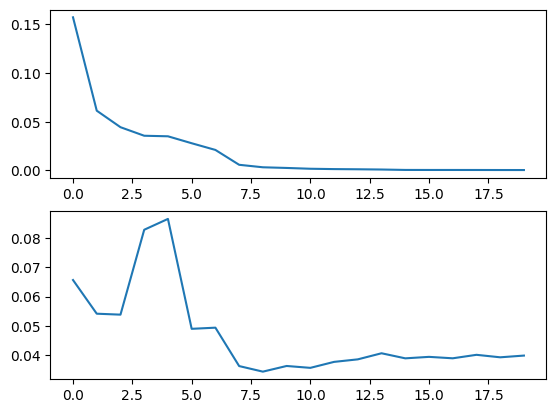

In [38]:
fig, axs = plt.subplots(nrows = 2, ncols = 1)
axs[0].plot([i for i in range(len(history['train_loss']))], history['train_loss'])
axs[1].plot([i for i in range(len(history['val_loss']))], history['val_loss'])


In [69]:
from sklearn.metrics import accuracy_score
import numpy as np

def test(model, test_dataset):
    model.eval()
    all_preds, all_answers = [], []
    for X_test, Y_test in test_dataloader:
        with set_grad_enabled(False):
            preds = argmax(model(X_test), 1)
        all_preds = np.hstack((all_preds, preds.numpy()))
        all_answers = np.hstack((all_answers, Y_test.numpy()))

    return accuracy_score(all_answers, all_preds, normalize = True)

In [70]:
test(model, test_dataloader)

0.9911